['Beta' 'E484K' 'N501Y' 'Wuhan-Hu-1' 'Delta']
           target     bind
11           Beta  9.30710
4031        E484K  8.96107
8051        N501Y  9.95503
12071  Wuhan-Hu-1  8.77161
16091       Delta  9.03525
['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']


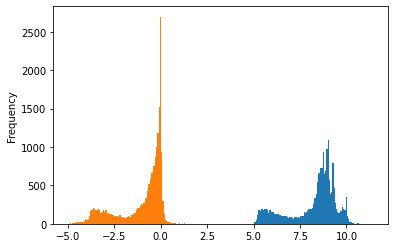

In [1]:
#Generate sequences for all mutations in deep mutational scan covid spike RBD experiment 
#! pip install Bio
import pandas as pd
import Bio
from Bio import SeqIO
from Bio import SeqRecord
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import matplotlib.pyplot as plt
from Bio.Seq import MutableSeq
#import tabulate

# read and get constants
url = 'https://media.githubusercontent.com/media/jbloomlab/SARS-CoV-2-RBD_DMS_variants/main/results/final_variant_scores/final_variant_scores.csv'
df = pd.read_csv(url) 

strains = df['target'].unique() # getting strain names from the df
pos = df['position'].unique()
aa = df['mutant'].unique()
plt.figure()
df['bind'].plot.hist(bins=100)
df['delta_bind'].plot.hist(bins=100)
print(strains)
print(df[(df['wildtype'] == df['mutant']) & (df['position'] == 331)][['target','bind']])
#print(pos)
print(aa)

In [2]:
#strains = ['Beta', 'E484K', 'N501Y', 'Wuhan-Hu-1', 'Delta']
# vectorized computation is preferable to iteration
# define functions:
def get_wt(df, strain_name): # get wt seq
    dfStrain = df.loc[(df['target'] == strain_name) & (df['wildtype'] == df['mutant']) ] # get wt aa's for a strain
    aa = dfStrain['wildtype'].str.cat() # cat a series to a string
    return(aa)

def get_binds(df): # get bind values, with ref+mutation as key (tuple)
    dict1 = df[['target', 'mutation', 'position', 'wildtype', 'mutant', 'bind', 'delta_bind']].to_dict('records')
    dict2 = {}
    for i in dict1:
        dict2[ (i['target'], i['mutation']) ] = {'bind': i['bind'], 
                                                 'd_bind': i['delta_bind'], 
                                                 'ref': i['target'],
                                                 'pos': i['position'],
                                                 'wt': i['wildtype'],
                                                 'mut': i['mutant']
                                                }
    return(dict2)
#print(get_binds(df, 20))    

In [25]:
# collect all info (seq, bind) in rowDict
wtSeq = {} # store wt as a dict so it could be matached to bind values
wtSeqRec = []
for strain in strains: 
    seqRec = SeqRecord(
        Seq(get_wt(df, strain)),
        id = strain + "_WT",
        )
    wtSeq[strain]= seqRec
    wtSeqRec.append(seqRec)
#print(wtSeq)
with open("wt.fas","w") as out_fh:
  SeqIO.write(wtSeqRec, out_fh, 'fasta')

rowDict = get_binds(df)
wtDict = {}
mutDict = {}
for rec in rowDict:
    #print(rowDict[rec])
    if rowDict[rec]['wt'] == rowDict[rec]['mut']: # wt
        rowDict[rec]['seq'] = wtSeq[rec[0]]
        wtDict[rec[0]] = rowDict[rec]
    else: # mutant
        sequence = MutableSeq(wtSeq[rec[0]].seq)
        #print(sequence)
        #print(type(int(rowDict[rec]['pos'] - pos[0])))
        sequence[int(rowDict[rec]['pos'] - pos[0]) ] = rowDict[rec]['mut']
        #print(sequence)
        rowDict[rec]['seq'] = SeqRecord(Seq(sequence), id = rec[1])
        mutDict[rec] = rowDict[rec]
#print([ [x, wtDict[x]['bind']] for x in wtDict])
print(list(mutDict.items())[0:3])

[(('Beta', 'N331A'), {'bind': 9.41007, 'd_bind': 0.10297, 'ref': 'Beta', 'pos': 331, 'wt': 'N', 'mut': 'A', 'seq': SeqRecord(seq=Seq('AITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSP...KST'), id='N331A', name='<unknown name>', description='<unknown description>', dbxrefs=[])}), (('Beta', 'N331C'), {'bind': 9.11229, 'd_bind': -0.19481, 'ref': 'Beta', 'pos': 331, 'wt': 'N', 'mut': 'C', 'seq': SeqRecord(seq=Seq('CITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSP...KST'), id='N331C', name='<unknown name>', description='<unknown description>', dbxrefs=[])}), (('Beta', 'N331D'), {'bind': 9.31717, 'd_bind': 0.01007, 'ref': 'Beta', 'pos': 331, 'wt': 'N', 'mut': 'D', 'seq': SeqRecord(seq=Seq('DITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSP...KST'), id='N331D', name='<unknown name>', description='<unknown description>', dbxrefs=[])})]


In [42]:
# filter sites with most epistatic shifts between targets
df_shift = pd.read_csv("../data/epi-shift.tsv", sep = "\t").to_dict("records")
#print(df_shift)
top_sites = [ site for site in df_shift if site['top'] is True ]
print(len(top_sites))

for x in mutDict:
    pick = False
    for rec in top_sites:
        if (mutDict[x]['pos'] == rec['position']) & (mutDict[x]['mut'] == rec['mutant']):
            pick = True
    mutDict[x]['pick'] = pick

print(len(mutDict))
pickRec = [ rec for rec in mutDict if mutDict[rec]['pick'] ]
print(len(pickRec))

39
19095
190


['E484K', 'N501Y', 'Delta', 'Beta_V503T']
189


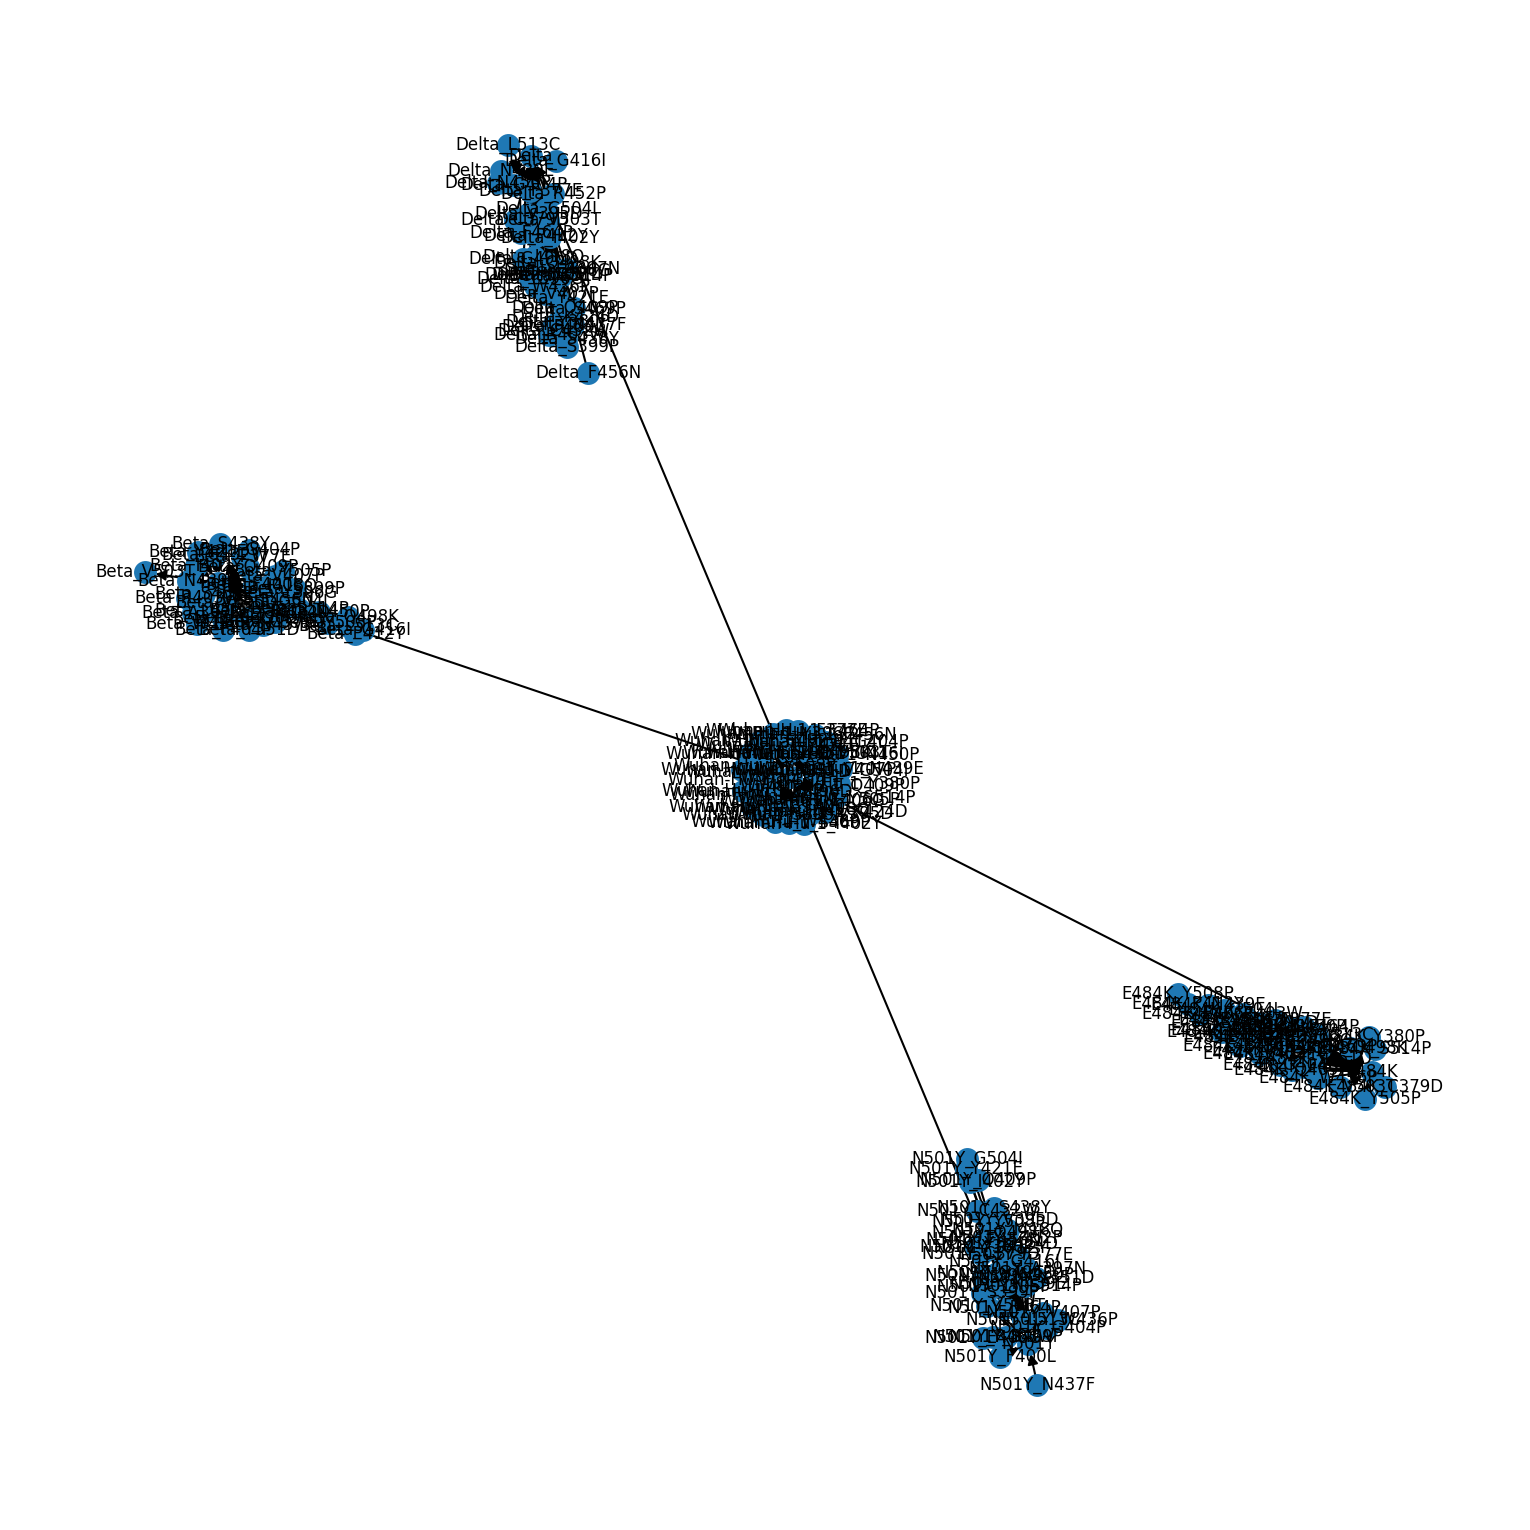

In [41]:
# build a directed graph
import networkx as nx

DG = nx.DiGraph() # a directed graph, there is lots of graph algorithms to identify local and global peaks; apply evol algo
for strain in wtDict: # add wt
    DG.add_node(strain) # add a node with a string name (id)
    # add levels for multipartite display
    if strain == 'Wuhan-Hu-1':
        DG.nodes[strain]['subset'] = 0 # Wuhan
    else:
        DG.nodes[strain]['subset'] = 1 # other 4 WTs
        
    for k in wtDict[strain]: # attach features: hap & fit 
        DG.nodes[strain][k] = wtDict[strain][k]

#pickSites = [ site['position'] for site in top_sites ] # show these sites only (polymorphic among WTs)
# pickLevels = {417:2, 452:3, 478:4, 484:5, 501:6}
#pickSites = [417, 501] # show these sites only
#pickAAs = ['A'] # pick a single AA mutation


for rec in pickRec: # add mut & edge
    id = rec[0] + "_" + rec[1]
    DG.add_node(id)
    for k in mutDict[rec]:
        DG.nodes[id][k] = mutDict[rec][k]
        
    #DG.nodes[id]['subset'] = pickLevels[mutDict[rec]['pos']] # add levels

    if wtDict[rec[0]]['bind'] < mutDict[rec]['bind']: # higher bind for mut    
        DG.add_edge(rec[0], id)
    else:
        DG.add_edge(id, rec[0])
# add edges between WTs    
DG.add_edge(strains[3], strains[1]) # wuhan -> E484
DG.add_edge(strains[3], strains[2]) # wuhan -> N501Y
DG.add_edge(strains[3], strains[0]) # wuhan -> beta
#DG.add_edge(strains[2], strains[0]) # N501Y -> beta
DG.add_edge(strains[3], strains[4]) # wuhan -> delta
#print(DG.nodes)
#print(DG.edges)

plt.figure(figsize = (10,10), dpi=150)
nx.draw(DG, with_labels = True, 
        node_size = 100,
        #node_color = ['orange'] * 5 + ['lightgray'] * 10,
        #edgecolors = ['red'] * 5 + ['black'] * 10,
        font_size = 8)
#plt.show()
plt.savefig("graph.png")
#print(DG.adj[strains[0]])
        
peaks = [x[0] for x in DG.out_degree if x[1] == 0]
vals = [x[0] for x in DG.in_degree if x[1] == 0]
print(peaks)
print(len(vals))

In [31]:
import matplotlib as mpl
import matplotlib.cm as cm

print(DG)
# map fitness to color map
norm = mpl.colors.Normalize(vmin=min(df['bind']), vmax=max(df['bind']))
mapper = cm.ScalarMappable(norm=norm, cmap=mpl.cm.cool)
NodeColors = [ mapper.to_rgba(DG.nodes[v]['bind']) for v in DG.nodes  ]
#peakLabels = peakG.nodes()
#print(peakNodeColors)


DiGraph with 195 nodes and 194 edges


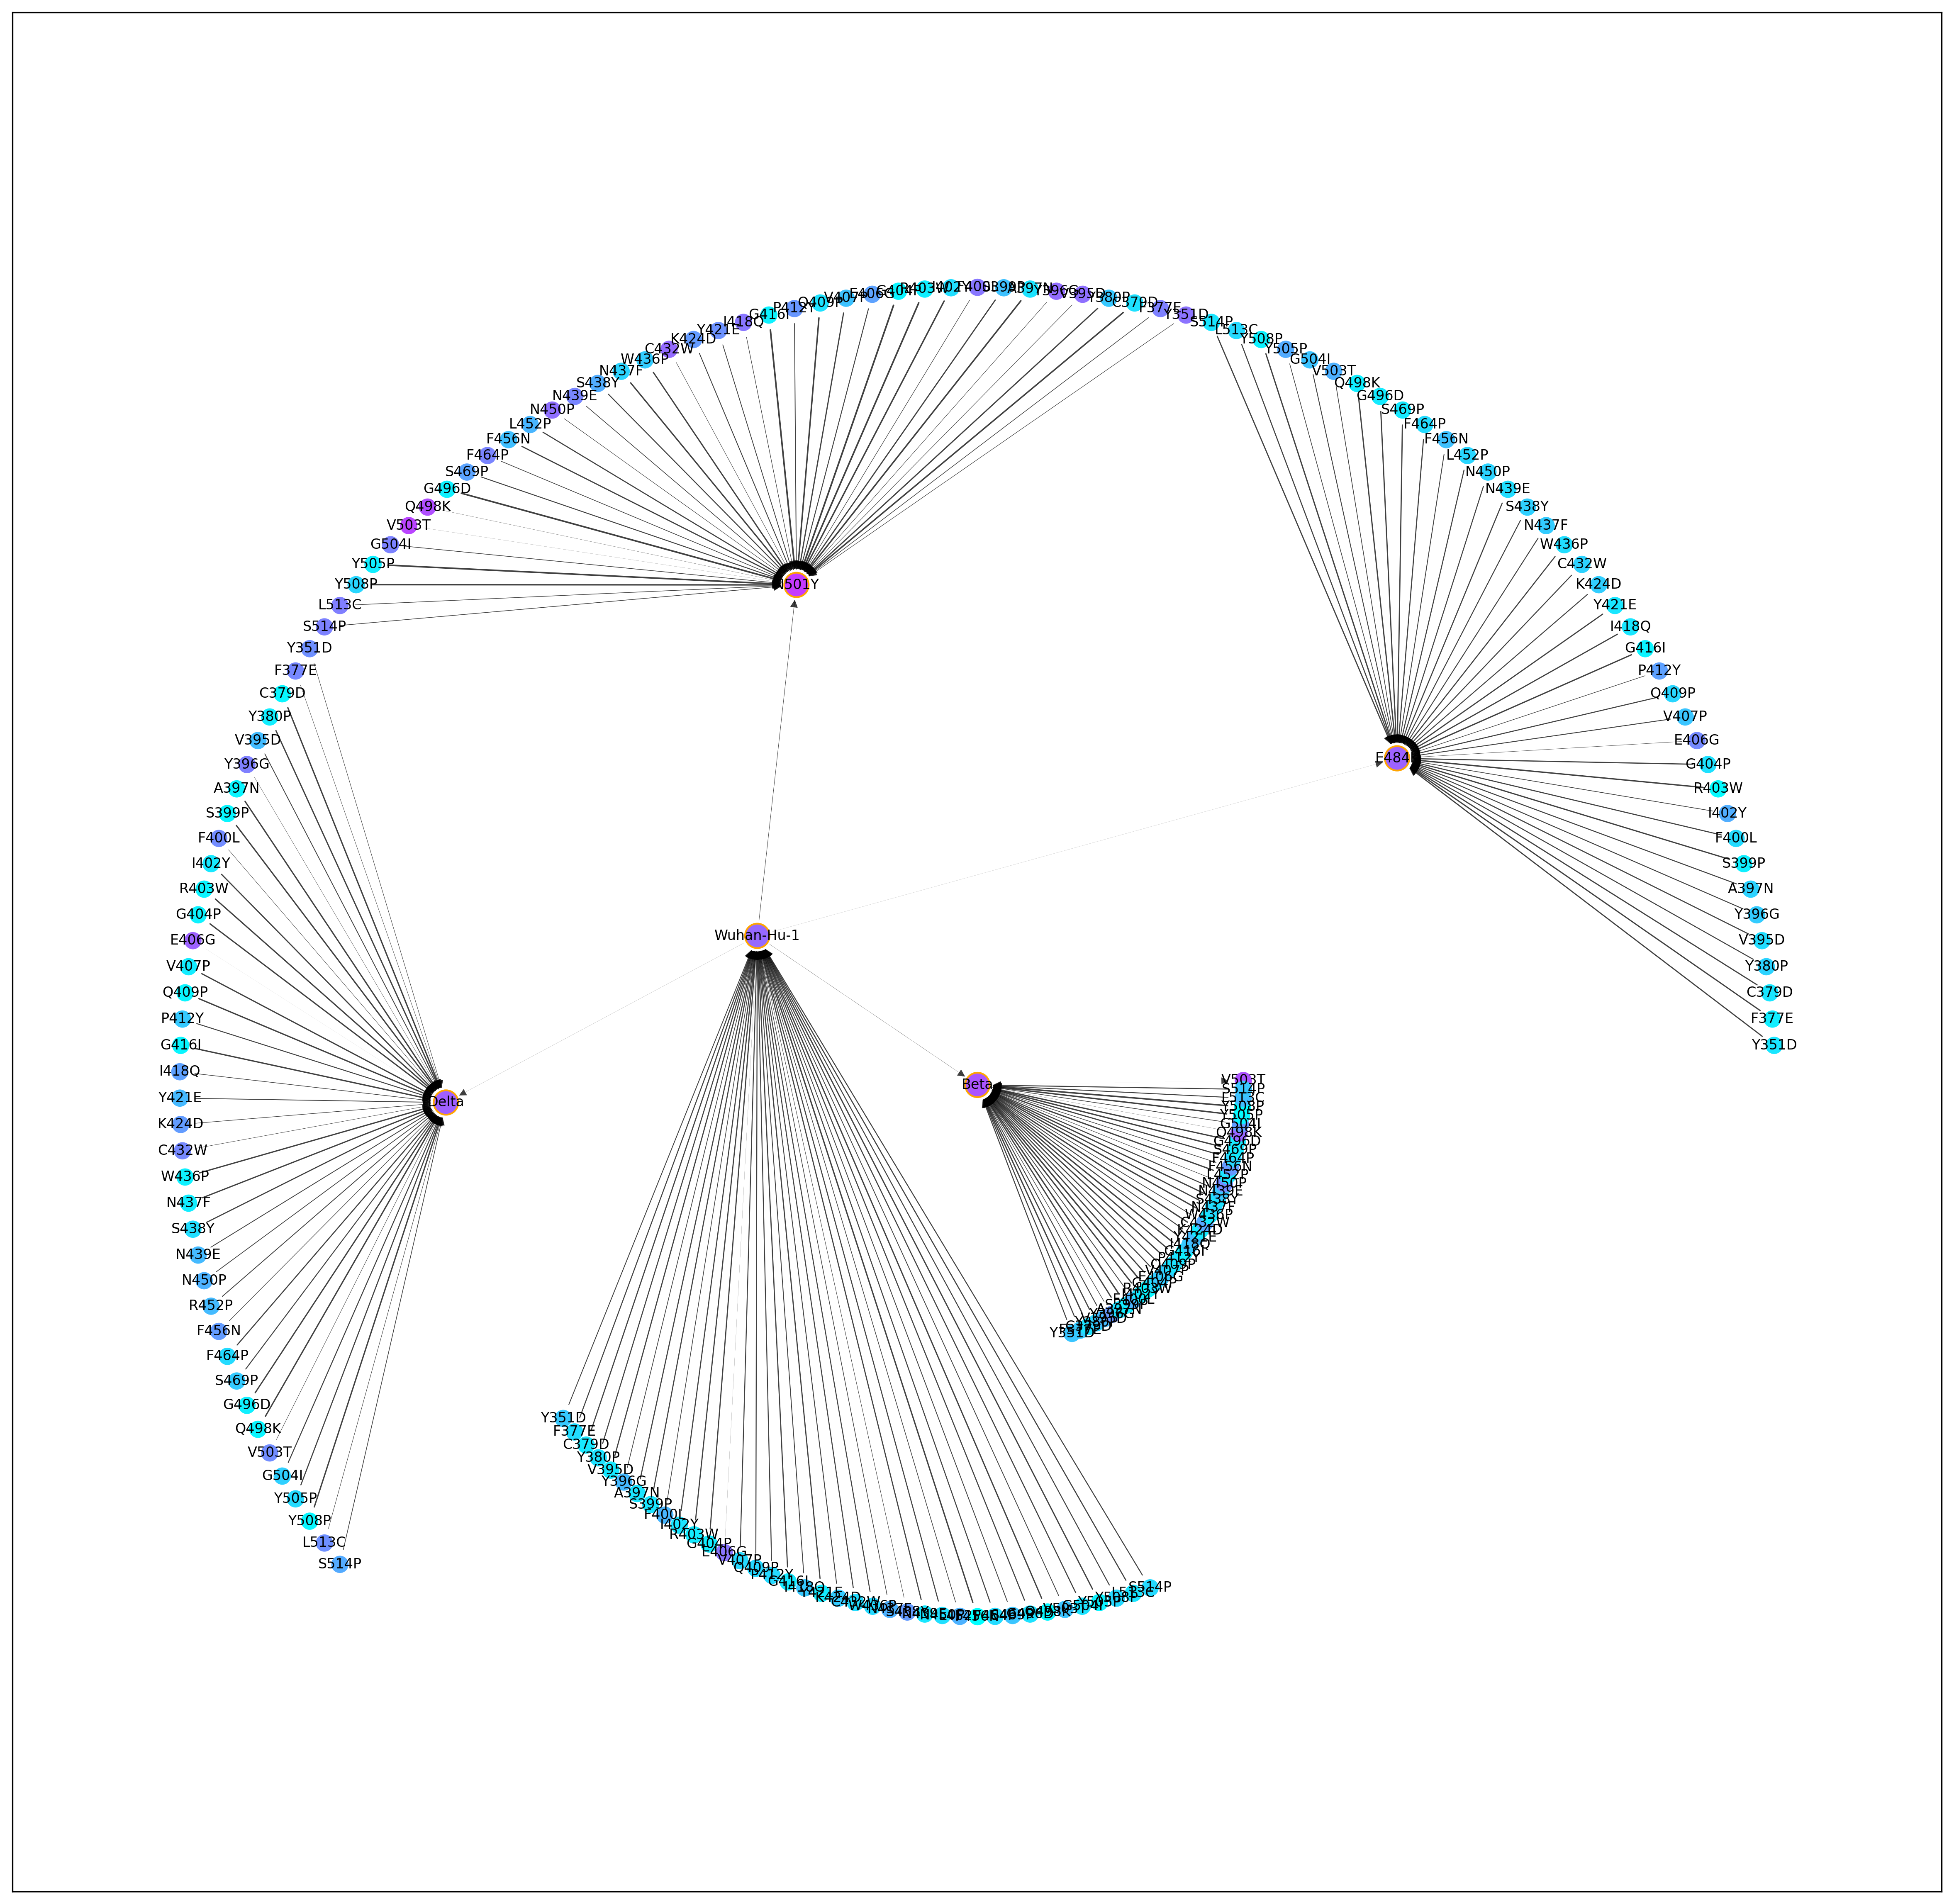

<Figure size 432x288 with 0 Axes>

In [38]:
# circular layout
import re
NodeSizes = [ 200 if x in strains  else 100 for x in DG.nodes ]
NodeEdges = [ "orange" if x in strains  else "none" for x in DG.nodes ]
EdgeWidth = [ abs(DG.nodes[x[0]]['bind']-DG.nodes[x[1]]['bind'])/5 for x in DG.edges() ]

pos = nx.nx_agraph.graphviz_layout(DG, prog="twopi", args="")
plt.figure(figsize=(20, 20), dpi=300)
ec = nx.draw_networkx_edges(DG, pos, alpha=0.75, width=EdgeWidth)
nc = nx.draw_networkx_nodes(DG, pos, 
                            node_color=NodeColors, 
                            node_size=NodeSizes, 
                            edgecolors=NodeEdges
                            )

# customize node labels
labels = {x:re.sub(r"^.+_", "", x) for x in DG.nodes}
#print(labels)
labs = nx.draw_networkx_labels(DG, pos, labels, font_size =8)
#nx.draw(DG, pos, node_size=20, alpha=0.5, node_color="blue", with_labels=False)
plt.axis("equal")
plt.show()
plt.savefig("cov.png")
#print(labs)
#labs = {n:re.sub(r"^.+_", "", lab.get_text()) for n,lab in labs.items() if n in pos}
#print(labs)

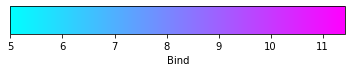

In [33]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.cool
#norm = mpl.colors.Normalize(vmin=5, vmax=10)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Bind')